In [102]:
import pandas_datareader as data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import yfinance as yf

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Flatten, InputLayer,
                                     Conv1D, MaxPool1D,
                                     Reshape,
                                     LSTM, GRU)
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
%matplotlib inline

In [4]:
def plot_curves(train_data, val_data, label='Accuracy'):
    """Plot training and validation metrics on single axis.

    Args:
        train_data: list, metrics obtrained from training data.
        val_data: list, metrics obtained from validation data.
        label: str, title and label for plot.
    Returns:
        Matplotlib plot.
    """
    plt.plot(np.arange(len(train_data)) + 0.5,
             train_data,
             "b.-", label="Training " + label)
    plt.plot(np.arange(len(val_data)) + 1,
             val_data, "r.-",
             label="Validation " + label)
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel(label)
    plt.grid(True)  

**Data (intra-day)**

In [5]:
intraday_data = yf.download(tickers="MSFT",
                            period="2y",
                            interval="1h",
                            auto_adjust=True)
intraday_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
2020-06-18 09:30:00-04:00,194.000000,196.490005,194.000000,194.910004,5495199
2020-06-18 10:30:00-04:00,194.880005,196.279999,194.250000,195.949997,3102091
2020-06-18 11:30:00-04:00,195.899994,196.000000,194.929993,195.369995,2113621
2020-06-18 12:30:00-04:00,195.385605,195.669907,195.210007,195.550095,1450587
2020-06-18 13:30:00-04:00,195.557007,196.029999,195.039993,195.259995,1883993


**Microsoft close prices**

In [6]:
pd.options.plotting.backend = "plotly"
intraday_data.plot(y=['Open'])

In [7]:
sequence_opens = intraday_data.values[: , 0]
sequence_opens.shape

(3527,)

**Split and flip data randomly**

In [8]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [9]:
# choose a number of time steps
n_steps = 7
# split into samples
X, y = split_sequence(sequence_opens, n_steps)

In [10]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)
n_train = int(0.8*X.shape[0])
n_val = int(0.9*X.shape[0])
X_train, y_train = X[:n_train, :], y[:n_train]
X_val, y_val = X[n_train:n_val, :], y[n_train:n_val]
X_test, y_test = X[n_val:, :], y[n_val:]

In [11]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

### Linear model


In [12]:
model = Sequential()

model.add(Flatten())

model.add(Dense(units=1,
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

model.compile(optimizer=Adam(lr=0.001),
              loss='mae',
              metrics=['mse'])

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


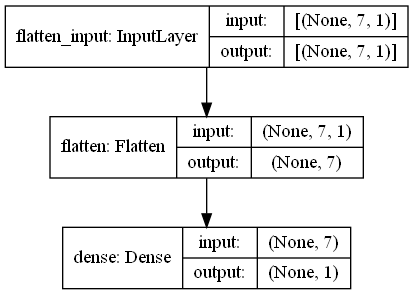

In [13]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

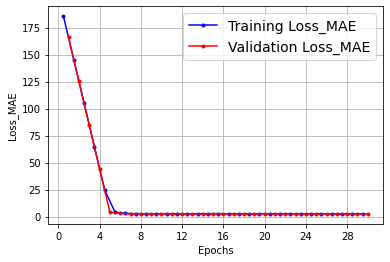

In [14]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss_MAE')

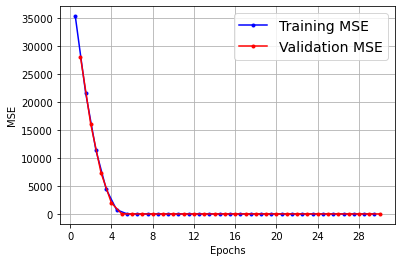

In [15]:
plot_curves(history.history['mse'],
            history.history['val_mse'],
            label='MSE')

11/11 [==============================] - 0s 1ms/step


Text(0, 0.5, 'Test Values')

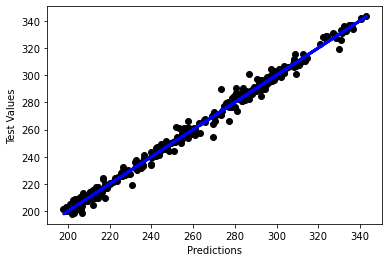

In [16]:
Y_predicted = model.predict(X_test, verbose=1)
plt.scatter(Y_predicted, y_test,  color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)
plt.xlabel("Predictions")
plt.ylabel("Test Values")

### Deep Neural Network

In [56]:
dnn_hidden_units = [16, 8]

model = Sequential()
for layer in dnn_hidden_units:
    model.add(Dense(units=layer,
                    activation="relu"))

model.add(Flatten())


model.add(Dense(units=1,
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

model.compile(optimizer=Adam(lr=0.001),
              loss='mae',
              metrics=['mse'])

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    verbose=0)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 7, 16)             32        
_________________________________________________________________
dense_22 (Dense)             (None, 7, 8)              136       
_________________________________________________________________
flatten_10 (Flatten)         (None, 56)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 57        
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


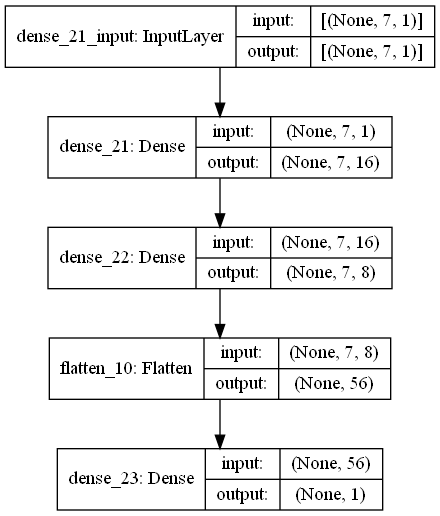

In [57]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

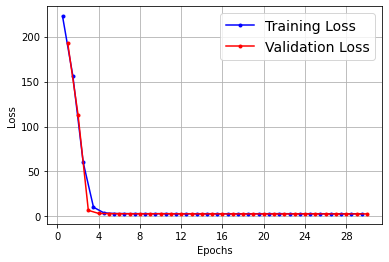

In [58]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss')

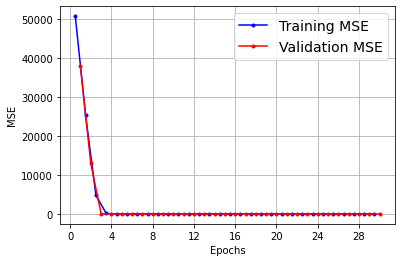

In [59]:
plot_curves(history.history['mse'],
            history.history['val_mse'],
            label='MSE')

11/11 [==============================] - 0s 1ms/step


Text(0, 0.5, 'Test Values')

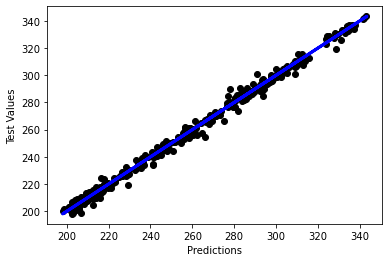

In [60]:
Y_predicted = model.predict(X_test, verbose=1)
plt.scatter(Y_predicted, y_test,  color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)
plt.xlabel("Predictions")
plt.ylabel("Test Values")

### Last Model (Temporal Convolutional Network with Dilation and causal convolution)


In [113]:
model = Sequential()
model.add(InputLayer(input_shape=[n_steps, 1]))
for dilation_rate in (1, 2, 4):
    model.add(
      Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(Conv1D(filters=64, kernel_size=1))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae', metrics=['mse'])

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 7, 32)             96        
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 7, 32)             2080      
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 7, 32)             2080      
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 7, 64)             2112      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 3, 64)             0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 192)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 50)              

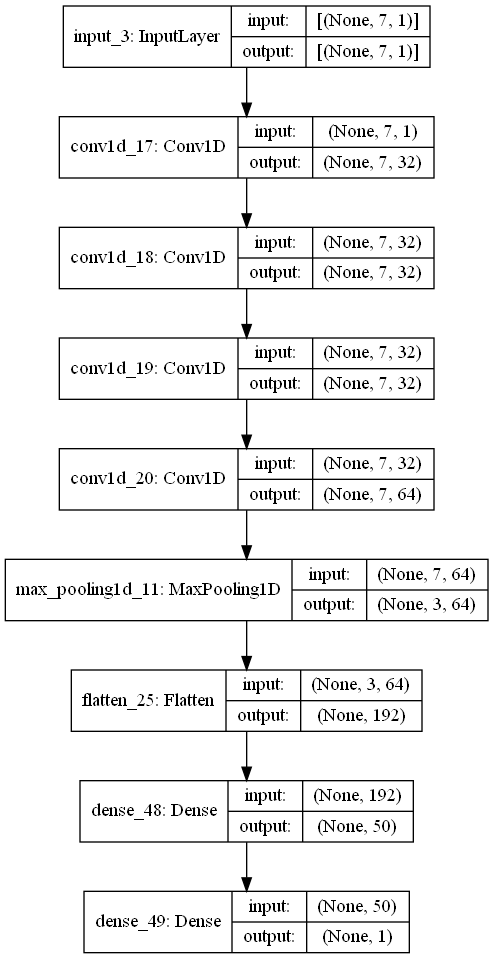

In [114]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [115]:
history = model.fit(
    X_train,
    y_train,
    batch_size=8,
    epochs=100,
    validation_data=(X_val, y_val),
    verbose=0)

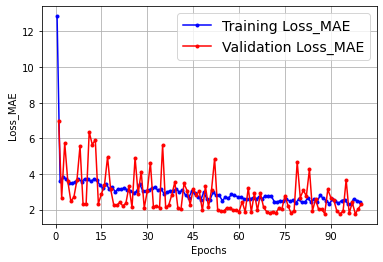

In [116]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss_MAE')

In [117]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=16)
print("test loss, test acc:", results)

Evaluate on test data
22/22 [==============================] - 0s 1ms/step - loss: 2.3382 - mse: 8.3005
test loss, test acc: [2.3382279872894287, 8.300514221191406]


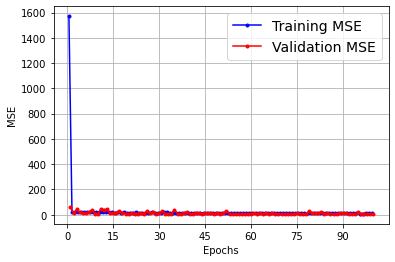

In [118]:
plot_curves(history.history['mse'],
            history.history['val_mse'],
            label='MSE')

11/11 [==============================] - 0s 1ms/step


Text(0, 0.5, 'Test Values')

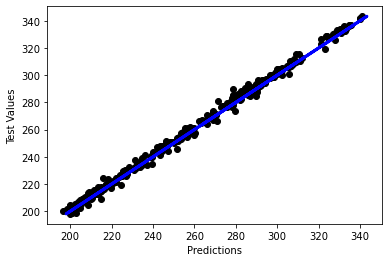

In [119]:
Y_predicted = model.predict(X_test, verbose=1)
plt.scatter(Y_predicted, y_test,  color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)
plt.xlabel("Predictions")
plt.ylabel("Test Values")

### Recurrent Neural Network


In [125]:
model = Sequential()

# Reshape inputs to pass through RNN layer.
model.add(Reshape(target_shape=[n_steps, 1]))
model.add(LSTM(n_steps // 2,
               activation='relu',
               return_sequences=False))

model.add(Dense(units=1,
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

# Create the model.
model.compile(optimizer=Adam(lr=0.001),
              loss='mae',
              metrics=['mse'])

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=8,
                    validation_data=(X_val, y_val),
                    epochs=40,
                    verbose=0)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_19 (Reshape)         (None, 7, 1)              0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 3)                 60        
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


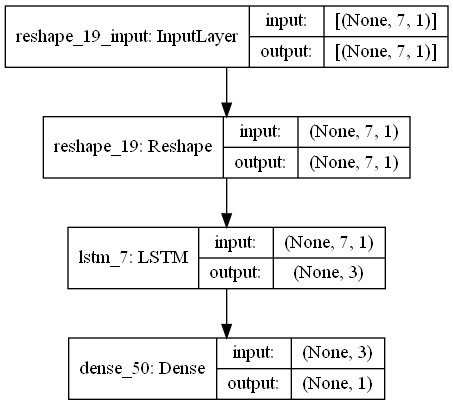

In [121]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

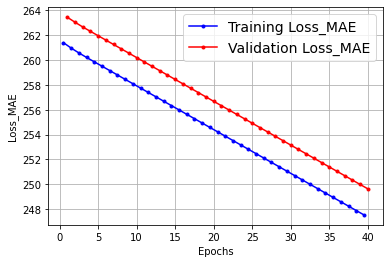

In [126]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss_MAE')

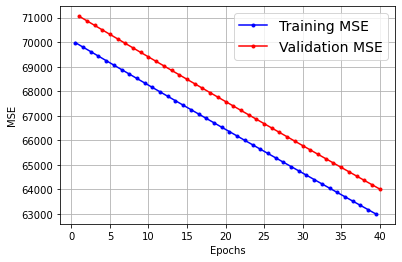

In [127]:
plot_curves(history.history['mse'],
            history.history['val_mse'],
            label='MSE')

11/11 [==============================] - 0s 1ms/step


Text(0, 0.5, 'Test Values')

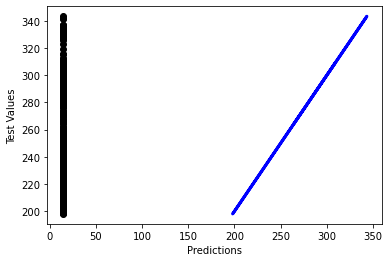

In [128]:
Y_predicted = model.predict(X_test, verbose=1)
plt.scatter(Y_predicted, y_test,  color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)
plt.xlabel("Predictions")
plt.ylabel("Test Values")

### Multi-layer RNN


In [129]:
rnn_hidden_units = [n_steps // 2,
                    n_steps // 4]

model = Sequential()

# Reshape inputs to pass through RNN layer.
model.add(Reshape(target_shape=[n_steps, 1]))

for layer in rnn_hidden_units[:-1]:
    model.add(GRU(units=layer,
                  activation='relu',
                  return_sequences=True))

model.add(GRU(units=rnn_hidden_units[-1],
              return_sequences=False))


model.add(Dense(units=1,
                kernel_regularizer=tf.keras.regularizers.l1(l=0.1)))

model.compile(optimizer=Adam(lr=0.001),
              loss='mae',
              metrics=['mse'])

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=8,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    verbose=0)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_17 (Reshape)         (None, 7, 1)              0         
_________________________________________________________________
gru_4 (GRU)                  (None, 7, 3)              54        
_________________________________________________________________
gru_5 (GRU)                  (None, 1)                 18        
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 2         
Total params: 74
Trainable params: 74
Non-trainable params: 0
_________________________________________________________________


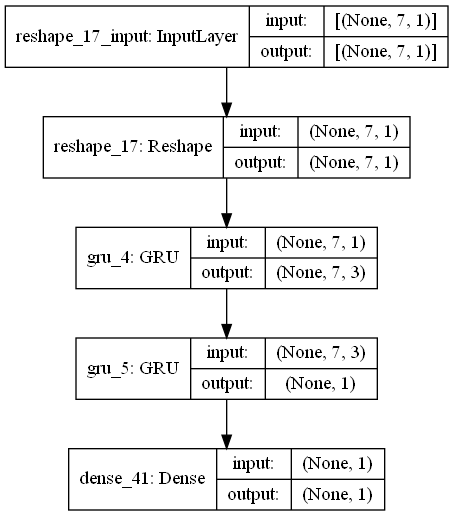

In [96]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

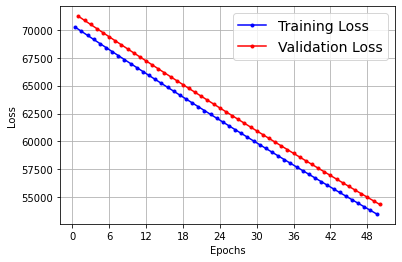

In [130]:
plot_curves(history.history['loss'],
            history.history['val_loss'],
            label='Loss_MAE')

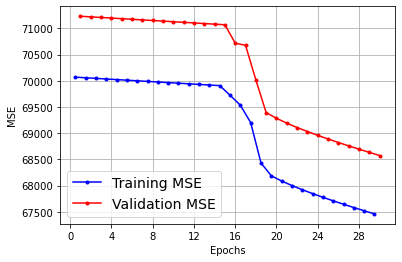

In [135]:
plot_curves(history.history['mse'],
            history.history['val_mse'],
            label='MSE')

11/11 [==============================] - 0s 2ms/step


Text(0, 0.5, 'Test Values')

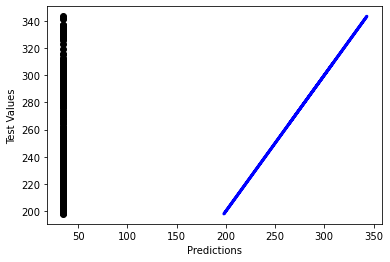

In [132]:
Y_predicted = model.predict(X_test, verbose=1)
plt.scatter(Y_predicted, y_test,  color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)
plt.xlabel("Predictions")
plt.ylabel("Test Values")